# Aim

I'm not convinced that HCIPy's modal decomposition of phase screens really works the way I understand it to work, so I'm going to redo the transformation matrix/least-squares decomposition from scratch here. No ModalAdaptiveOpticsLayer objects here.

In [1]:
# imports

import sys
sys.path.append("..")
from hcipy.hcipy import *
import numpy as np
from matplotlib import pyplot as plt
from scipy.interpolate import interp1d
%matplotlib inline

In [2]:
# global parameter definitions

wavelength = 5e-7
dt    = 1/1000
T     = 1
nAct  = 21
D     = 10.95
r0    = 16.5e-2   
k     = 2 * np.pi / wavelength
scale = 0.6e-6
Z_DM = np.zeros([nAct,nAct])
binning_factor = 8
p  = nAct*binning_factor
pupil_grid = make_pupil_grid(p, D)
times = np.arange(0, T, dt)
g = make_pupil_grid(p, diameter=D)
mask = circular_aperture(D)(g)

In [3]:
modes = [i for i in range(0, 3)]
basis = np.vstack([zernike(*ansi_to_zernike(i), D=D, grid=g) for i in modes]).T

In [4]:
outer_scale   = 20 
wind_velocity = 15
Cn2           = r0**(-5. / 3) / (0.423 * k**2)

def turbulence_phases():
    # returns a list of Fields representing the turbulence phases over time
    single_layer_atmos = InfiniteAtmosphericLayer(pupil_grid,  Cn_squared=Cn2, L0=outer_scale, 
                                                  velocity=wind_velocity, use_interpolation=True)
    single_layer_turb = [None] * times.size
    for n in range(times.size):
        single_layer_atmos.evolve_until(times[n])
        turb = single_layer_atmos.phase_for(wavelength)
        single_layer_turb[n] = Field(turb, grid=g) * mask
    return single_layer_turb

In [5]:
phases = turbulence_phases()

In [6]:
# make the least-squares coefficients
coeffs = np.zeros((times.size, len(modes)))
basis_t = basis.T
ls_basis_inv = np.linalg.inv(basis_t.dot(basis)).dot(basis_t)
for i in range(times.size):
    coeffs[i] = ls_basis_inv.dot(phases[i])

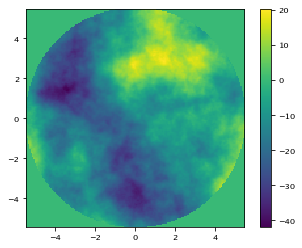

In [7]:
k = 200
imshow_field(phases[k])
plt.colorbar()

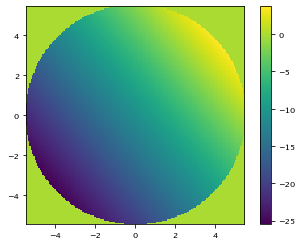

In [8]:
correction = Field(basis.dot(coeffs[k]), g)
imshow_field(correction)
plt.colorbar()

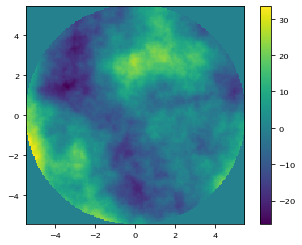

In [10]:
# see the residual phase screens
imshow_field(phases[k] - correction)
plt.colorbar()